## Correct the spectra by redshift and normalize it

In this notebook I'll make plots of the spectra at restframe wavelengths, and later normalize them.

- The wavelength for normalization will be at Balmer Break (3645): (0.343,0.3640)  $\mu m$
- The redshift range is: 2.27 to 9.29
- The restframe wavelength range for the whole sample is: 0.048 $\mu m$  to  1.68 $\mu m$
- The overlap range is between 0.15 to 0.53 $\mu m$


Caveats:
- I used 4 as the min number of points for the normalization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## importing libraries
from functions import load_spectrum, plot_spectrum_ax, make_spectrum_panel
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import pandas as pd

In [3]:
hdul = fits.open("deGraaff2025_lrds_withdups_blackbody_eline_fits.fits")
hdul.info()
data = hdul[1].data

files = data["file"]
redshifts = data["zspec"]

#transforming into numpy arrays
files = np.array(files)
redshifts = np.array(redshifts)

print(redshifts.min(), redshifts.max())

spec_info_all = list(zip(files, redshifts))

#removing info from the spectra of program MoM (GO5224) since we don't have its spectra
spec_info_clear = spec_info_all[:59] + spec_info_all[72:]
print(len(spec_info_clear))
print(spec_info_clear[:10])


Filename: deGraaff2025_lrds_withdups_blackbody_eline_fits.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  PHOT          1 BinTableHDU     94   134R x 32C   [K, K, 24A, 57A, D, D, D, D, D, K, 196A, L, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D]   
2.2734878 9.294025001594942
121
[(np.str_('capers-cos07-v4_prism-clear_6368_43711.spec.fits'), np.float64(4.42044)), (np.str_('capers-cos10-v4_prism-clear_6368_119334.spec.fits'), np.float64(9.294025001594942)), (np.str_('capers-cos10-v4_prism-clear_6368_30440.spec.fits'), np.float64(3.5045)), (np.str_('capers-cos10-v4_prism-clear_6368_32659.spec.fits'), np.float64(4.44217)), (np.str_('capers-cos13-v4_prism-clear_6368_160387.spec.fits'), np.float64(6.38003)), (np.str_('capers-cos19-v4_prism-clear_6368_4771.spec.fits'), np.float64(5.92735)), (np.str_('capers-cos19-v4_prism-clear_6368_9226.spec.fits'), np.float64(3.7241027)), (np.str_('

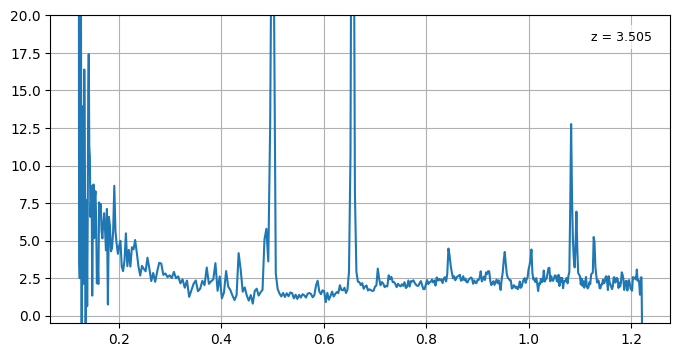

In [4]:
#For testing: Plotting a single spectrum.
## Change the index n of spec_info_clear[n][0] and spec_info_clear[n][1] to plot different spectra

# Load one spectrum
spec = load_spectrum(
    "DeGraaff_espectros/{}".format(spec_info_clear[2][0]),
    z=spec_info_clear[2][1],
    output_flux_scale=1e20
)

# Create a single axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot
plot_spectrum_ax(
    ax,
    spec,
    z=spec['z'],
    ylim=(-0.5, 20),
)

plt.show()

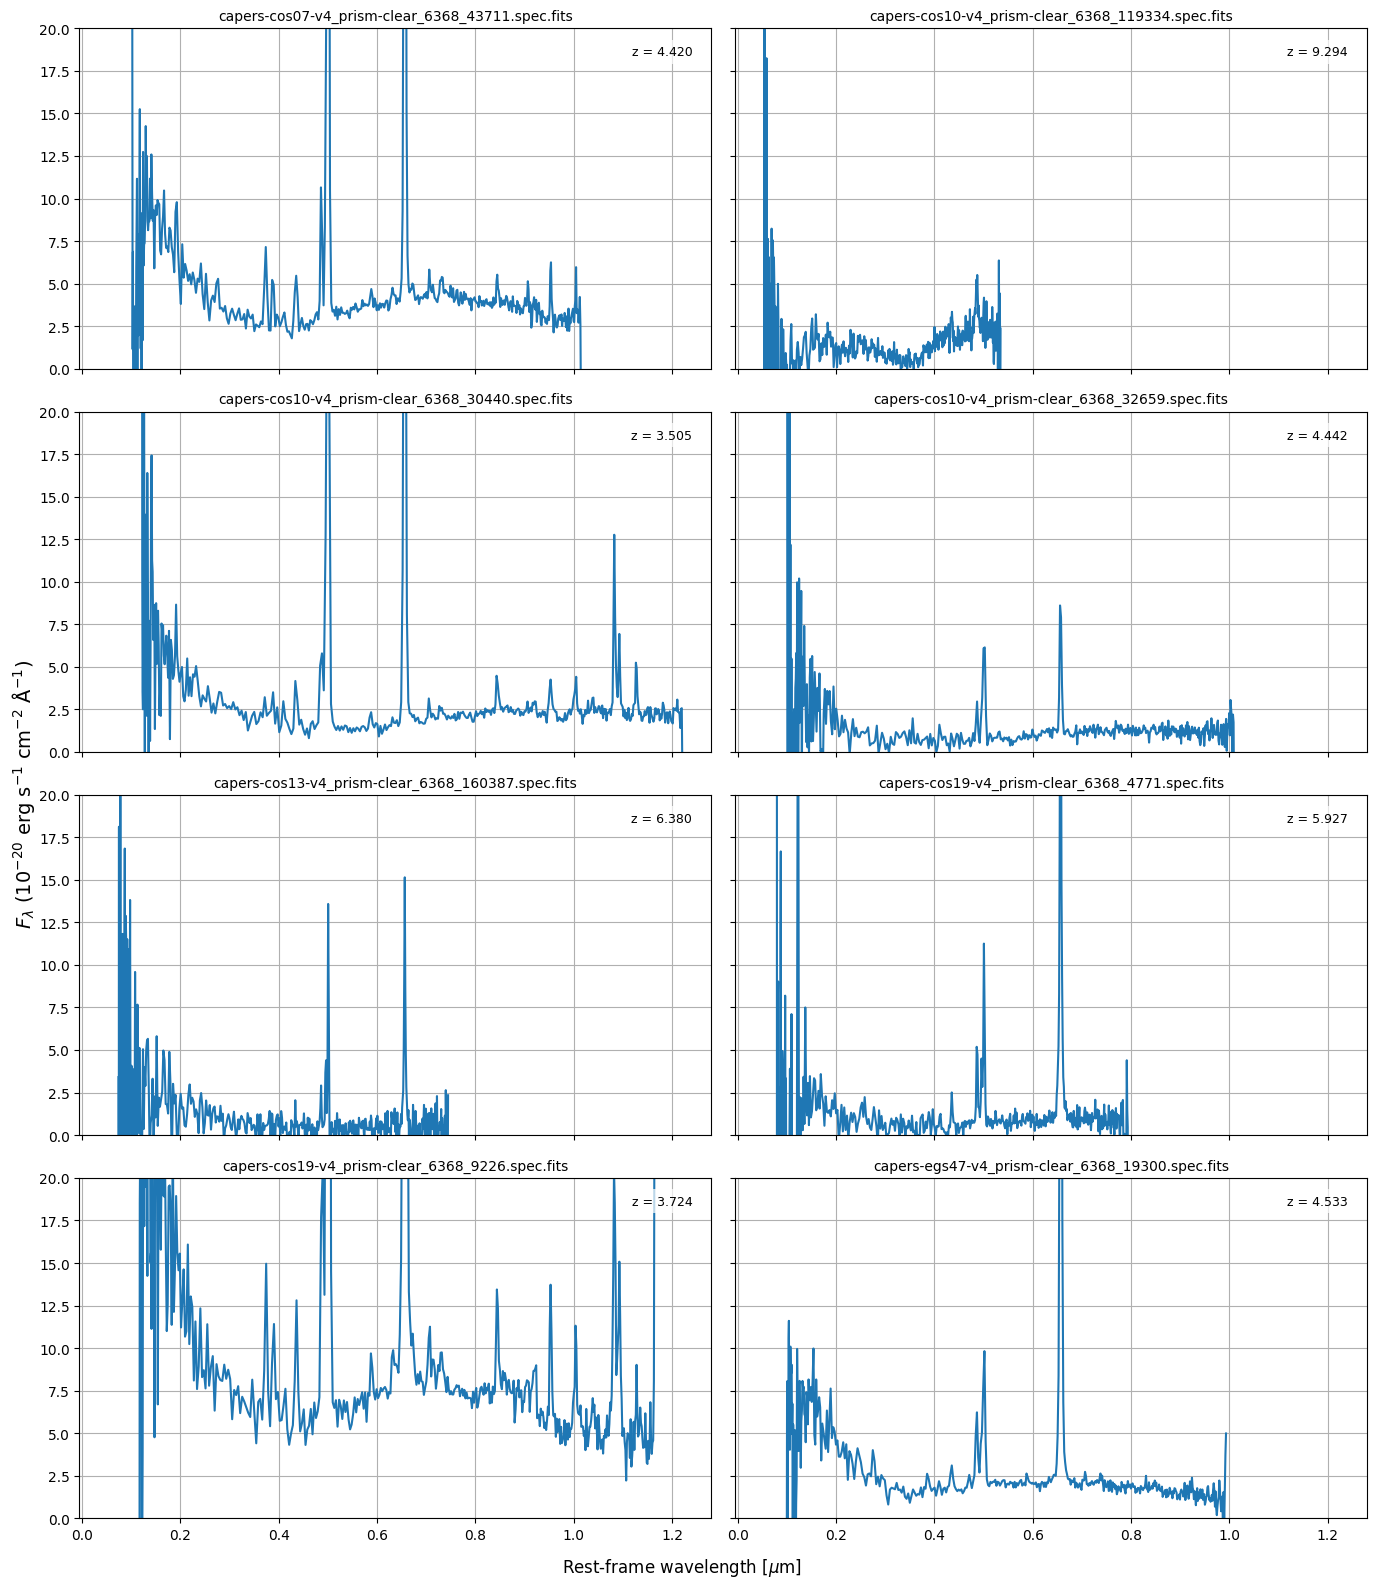

In [31]:
#example of a panel
fig = make_spectrum_panel(
    spec_info_clear,
    ylim=(0,20),
    loader_kwargs=dict(
        input_flux_unit="uJy",
        wave_unit="um",
        restframe=True,
        output_flux_scale=1e20,
    ),
    start=0
)


## Normalization

True


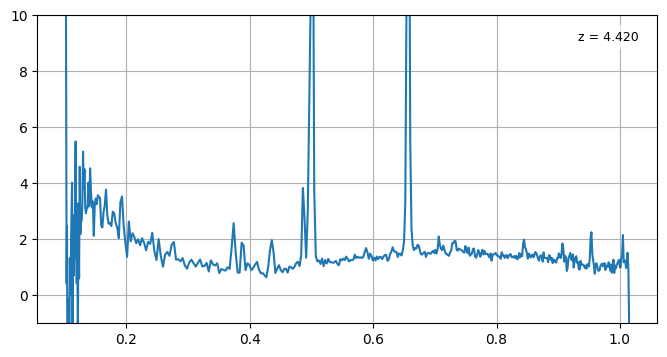

In [5]:
## testing normalization

# Load one spectrum
spec = load_spectrum(
    "DeGraaff_espectros/{}".format(spec_info_clear[0][0]),
    z=spec_info_clear[0][1],
    normalize=True
)

print(spec['normalized'])

# Create a single axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot
plot_spectrum_ax(
    ax,
    spec,
    z=spec['z'],
    ylim=(-1, 10),
)

plt.show()

⚠️ Skipping capers-egs47-v4_prism-clear_6368_212932.spec.fits, redshift 2.28602: normalization failed (Not enough points in normalization window (0.343, 0.364))


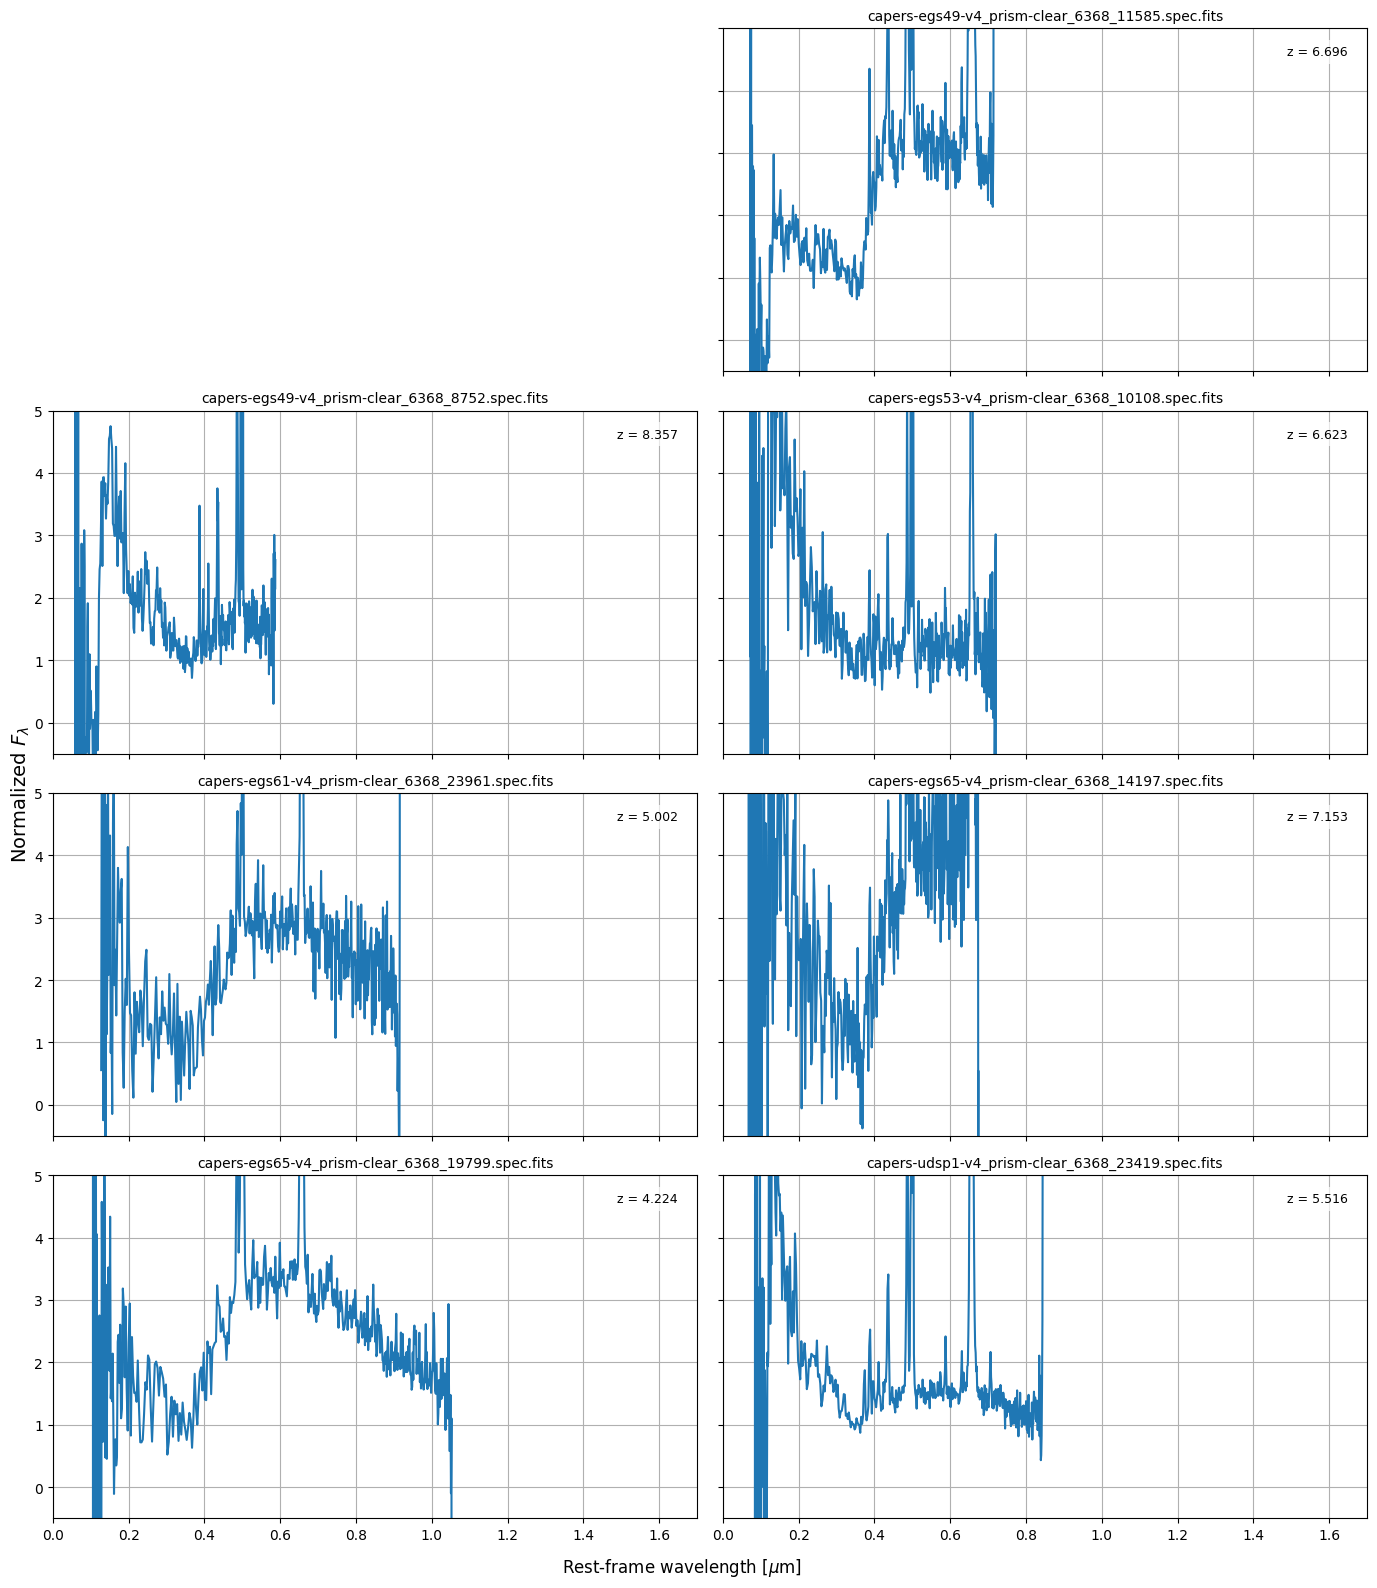

In [23]:
#example of a panel
fig = make_spectrum_panel(
    spec_info_clear,
    ylim=(-0.5,5),
    xlim=(0, 1.7),
    loader_kwargs=dict(
        input_flux_unit="uJy",
        wave_unit="um",
        restframe=True,
        normalize=True,
        norm_window=(0.3430,0.3640),
    ),
    start=8
)

In [52]:
#Plotting all panels
for start in range(0, len(spec_info_clear), 8):
    fig = make_spectrum_panel(
        spec_info_clear,
        ylim=(-0.5,15),
        xlim=(0, 1.7),
        loader_kwargs=dict(
            input_flux_unit="uJy",
            wave_unit="um",
            restframe=True,
            normalize=True,
            norm_window=(0.343,0.3640),
        ), 
        start=start)
    fig.savefig(f"Panels_normalized/spectra_panel_norm_{start//8:02d}.pdf")
    plt.close(fig)


⚠️ Skipping jades-gds-wide2-v4_prism-clear_1180_b398.spec.fits, redshift 7.24752023960155: normalization failed (Invalid normalization factor)


/home/bruna-araujo/Documentos/LRDs/functions/spectrum.py:31: RuntimeWarning: All-NaN slice encountered
  lam_cm = wave * 1e-8


⚠️ Skipping rubies-egs52-v4_prism-clear_4233_37124.spec.fits, redshift 5.68516: normalization failed (Invalid normalization factor)


/home/bruna-araujo/Documentos/LRDs/functions/spectrum.py:31: RuntimeWarning: All-NaN slice encountered
  lam_cm = wave * 1e-8


⚠️ Skipping rubies-uds22-v4_prism-clear_4233_139709.spec.fits, redshift 5.68399: normalization failed (Invalid normalization factor)
⚠️ Skipping rubies-uds33-v4_prism-clear_4233_53692.spec.fits, redshift 5.2792883: normalization failed (Invalid normalization factor)
⚠️ Skipping rubies-uds42-v4_prism-clear_4233_807469.spec.fits, redshift 6.7795324: normalization failed (Invalid normalization factor)
⚠️ Skipping rxj2129-ddt-v4_prism-clear_2767_11024.spec.fits, redshift 4.2948875: normalization failed (Invalid normalization factor)


False


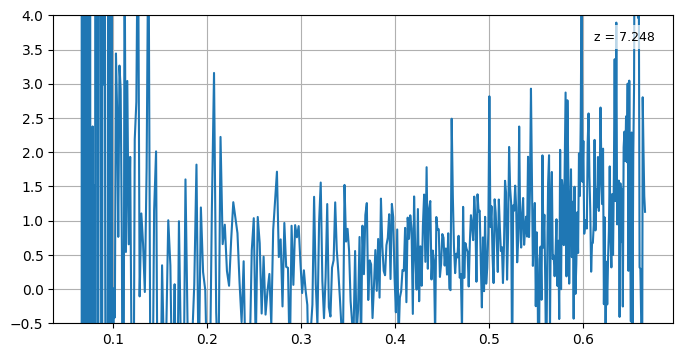

In [62]:
## plotting the errors

# Load one spectrum
spec = load_spectrum(
    "DeGraaff_espectros/jades-gds-wide2-v4_prism-clear_1180_b398.spec.fits",
    z=7.24752023960155,
    normalize=False,
    restframe=True,
    output_flux_scale=1e20
)

print(spec['normalized'])

# Create a single axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot
plot_spectrum_ax(
    ax,
    spec,
    z=spec['z'],
    ylim=(-0.5, 4),
)

plt.show()


## Saving File with norm factor

In [53]:

rows = []

for fname, z in spec_info_clear:
    spec = load_spectrum(
        f"DeGraaff_espectros/{fname}",
        z=z,
        input_flux_unit="uJy",
        wave_unit="um",
        restframe=True,
        normalize=True,
    )

    rows.append({
        "file": fname,
        "z": z,
        "normalized": spec["normalized"],
        "norm_factor": spec["norm_factor"],
        "norm_window_min": (
            spec["norm_window"][0] if spec["norm_window"] else np.nan
        ),
        "norm_window_max": (
            spec["norm_window"][1] if spec["norm_window"] else np.nan
        ),
        "norm_error": spec["norm_error"],
    })

df = pd.DataFrame(rows)
df.to_csv("normalization_factors.csv", index=False)

/home/bruna-araujo/Documentos/LRDs/functions/spectrum.py:31: RuntimeWarning: All-NaN slice encountered
  lam_cm = wave * 1e-8
